# Using PyDAP for remote data access
This notebook demonstrates simple how to use PyDAP to pull data from remote DAP servers into your Python programs memory space so that the data may be analyized and displayed.

In the notebook we show how to use simple HTTP requests to look at metadata and how to use the PyDAP package to read data into numpy arrays and plot (or do other things) with those data. PyDAP provides lazy evaluation, so data are read only when needed. 

Copyright (C) 2023 OPeNDAP, Inc.
This Jupyter Notebook is made available under the [Creative Commons Attribution license 4.0](https://creativecommons.org/licenses/by/4.0/).

In [1]:
# The requests package provides a high-level interface to HTTP/S
import requests

# Install using 'conda install requests'

# Use the netCDF4 library to read data
# from netCDF4 import Dataset as NetCDFFile 
# import xarray as xr
from pydap.client import open_url
from pydap.cas.urs import setup_session

# Install using 'conda install -c conda-forge pydap'

# Use matplotlib and numpy for plotting and local data manipulation
import matplotlib.pyplot as plt
import numpy as np

# These are part of the conda base

# Using basemap with Anaconda/Jupyter and Python 3, I had to set this env var.
# I might have been able to do this in the shell that started the notebook server,
# but that would obfuscate a detail that seems to generate considerable traffic on
# Stackoverflow... jhrg 4/22/20
# Maybe if I had used a conda environment other than 'base' this would not have been an issue
# jhrg 4/23/20
import os
os.environ['PROJ_LIB'] = '/Users/jimg/opt/anaconda3/pkgs/proj4-5.2.0-h0a44026_1/share/proj'

from mpl_toolkits.basemap import Basemap

# Install using 'conda install basemap'
# To plot hig resolution maps, use 'conda install basemap-data-highres'
# NB: We will need to shift to Cartopy soon...

from IPython.display import Code


In [2]:
dataset_url='http://test.opendap.org/opendap/data/nc/coads_climatology.nc'

## Look at the metadata
Lets look at the dataset's contents, first by looking at the variables in the dataset. We can do this by appending the extension _dds_ to the dataset's URL. The _Data Access Protocol_ denotes the different kinds of responses from a dataset using extensions. The most important ones are:
- **dds** Get information about the variables
- **das** Get semantic (i.e., attributes) about the dataset and its variables
- **dods** Get binary data (for individual or groups of variables)
- **ascii** Get data as ASCII, really useful for looking at small parts or a dataset

In [3]:
r = requests.get(dataset_url + '.' + 'dds')

In [4]:
print(r.url)

http://test.opendap.org/opendap/data/nc/coads_climatology.nc.dds


In [5]:
Code(r.text, language='C')

Dataset {
    Float64 COADSX[COADSX = 180];
    Float64 COADSY[COADSY = 90];
    Float64 TIME[TIME = 12];
    Grid {
      Array:
        Float32 SST[TIME = 12][COADSY = 90][COADSX = 180];
      Maps:
        Float64 TIME[TIME = 12];
        Float64 COADSY[COADSY = 90];
        Float64 COADSX[COADSX = 180];
    } SST;
    Grid {
      Array:
        Float32 AIRT[TIME = 12][COADSY = 90][COADSX = 180];
      Maps:
        Float64 TIME[TIME = 12];
        Float64 COADSY[COADSY = 90];
        Float64 COADSX[COADSX = 180];
    } AIRT;
    Grid {
      Array:
        Float32 UWND[TIME = 12][COADSY = 90][COADSX = 180];
      Maps:
        Float64 TIME[TIME = 12];
        Float64 COADSY[COADSY = 90];
        Float64 COADSX[COADSX = 180];
    } UWND;
    Grid {
      Array:
        Float32 VWND[TIME = 12][COADSY = 90][COADSX = 180];
      Maps:
        Float64 TIME[TIME = 12];
        Float64 COADSY[COADSY = 90];
        Float64 COADSX[COADSX = 180];
    } VWND;
} coads_climatology.nc;

From this we can see these data consist of four regularly gridded variables. 

Lets look at the dataset's attribute information. From this we can see the values used to denote 'missing' or filled values, units, etc.

In [6]:
r = requests.get(dataset_url + '.' + 'das')

In [7]:
Code(r.text, language='C')

Attributes {
    COADSX {
        String units "degrees_east";
        String modulo " ";
        String point_spacing "even";
    }
    COADSY {
        String units "degrees_north";
        String point_spacing "even";
    }
    TIME {
        String units "hour since 0000-01-01 00:00:00";
        String time_origin "1-JAN-0000 00:00:00";
        String modulo " ";
    }
    SST {
        Float32 missing_value -9.99999979e+33;
        Float32 _FillValue -9.99999979e+33;
        String long_name "SEA SURFACE TEMPERATURE";
        String history "From coads_climatology";
        String units "Deg C";
    }
    AIRT {
        Float32 missing_value -9.99999979e+33;
        Float32 _FillValue -9.99999979e+33;
        String long_name "AIR TEMPERATURE";
        String history "From coads_climatology";
        String units "DEG C";
    }
    UWND {
        Float32 missing_value -9.99999979e+33;
        Float32 _FillValue -9.99999979e+33;
        String long_name "ZONAL WIND";
        String history "From coads_climatology";
        String units "M/S";
    }
    VWND {
        Float32 missing_value -9.99999979e+33;
        Float32 _FillValue -9.99999979e+33;
        String long_name "MERIDIONAL WIND";
        String history "From coads_climatology";
        String units "M/S";
    }
    NC_GLOBAL {
        String history "FERRET V4.30 (debug/no GUI) 15-Aug-96";
    }
    DODS_EXTRA {
        String Unlimited_Dimension "TIME";
    }
}

## Peek at the data
Lets look at sea surface data over the Atlantic Ocean, pulling those values out of the dataset as ASCII. This would not be a good idea with millions of values, but for this dataset, it is not an issue. Later on, I'll show how you can so this using PyDAP, without the performance cost of having the server perform the conversion to ASCII. This is still a useful technique, even with larger datasets because when documentation and metadata leave you with questions, looking at a small set of values can be helpful.

For this, we will use the **grid()** server function - there are simpler ways to look at values, but this notebook is about server functions after all, so...

The **grid()** function takes a _grid_ variable, followed by a series of optional _expressions_. The expressions denote a range of values for the independent variables that make up the grid. In this case _COADSY_ and _COADSX_ are used. For any independent variables left unmentioned, grid() will return all the values. In this example below, we will get data that correspond to the values of _COADSY_ between 45 and -25, the values of _COADSX_ betwwen 20 and -100 and all the values corresponding to the TIME axis of the _SST_ grid.

In [89]:
ce = 'SST'

In [90]:
r2 = requests.get(dataset_url + '.' + 'ascii', params=ce)

In [91]:
print(r2.url)

http://test.opendap.org/opendap/data/nc/coads_climatology.nc.ascii?SST


In [92]:
# Uncomment this line to see the ASCII data. 
# print(r2.text)

## Using PyDAP to read values

In [142]:
pydap_ds = open_url(dataset_url)

In [143]:
print(pydap_ds)

<DatasetType with children 'COADSX', 'COADSY', 'TIME', 'SST', 'AIRT', 'UWND', 'VWND'>


In [144]:
pydap_ds.SST.shape

(12, 90, 180)

In [151]:
# Subset a geographical area at a single time point.
pydap_subset_ds = pydap_ds.SST[5,33:85,135:179]

In [152]:
print(pydap_subset_ds)

<GridType with array 'SST' and maps 'TIME', 'COADSY', 'COADSX'>


In [153]:
pydap_subset_ds.shape

(1, 52, 44)

### PyDAP only reads the data when  needed
The above call, just like the **open_url()** call, does not get data. The *access* to values in the cells below trigger the data transfers.

This assignment triggers a data read. Note that the grid 'SST' is being subset here.
Only the ''sliced' data are read. This is in addition to the subsetting performed by the grid() function. PyDAP enables constraints to be built up in this way, until an action like assignment triggers a read operation. This feature is often known as _lazy evaluation_ because the action can be _defined_ in stages and is not run until the values are needed.

In [158]:
time = pydap_subset_ds.TIME.data
print("time",time.shape)
lat = pydap_subset_ds.COADSY.data
print("latitude",lat.shape)
lon = pydap_subset_ds.COADSX.data
print("longitude",lon.shape)
sst = pydap_subset_ds.array.data
print("SST",sst.shape,)

time (1,)
latitude (52,)
longitude (44,)
SST (1, 52, 44)


In [159]:
# Replace the FillValues in the range data with NaNs so the opltting code doesn't barf

#it = np.nditer(sst, flags=['c_index'])
#for i in it:
#    if i < -8.9999998e+33:
#            print('Found it. i[%d]: %f',it.index, i)
#            sst[it.index] = np.nan
   
#if np.all(sst < -8.9999998e+33):
#    print('Found it. i[%d]: %f',it.index, i)
    #sst[it.index] = np.nan

# Remove the _FillValue value
sst[sst < -8.9999998e+33] = np.nan

print("SST: ",sst)


SST:  [[[        nan         nan         nan ... 15.36875    14.025333
           nan]
  [        nan         nan         nan ... 16.04077    15.466666
           nan]
  [        nan         nan         nan ... 15.945555           nan
           nan]
  ...
  [-1.4233333  -0.24499999 -0.635      ...  4.791333    4.5927777
    4.1543903 ]
  [-0.59999996         nan         nan ...  3.449091    2.8216665
    1.5455999 ]
  [        nan         nan         nan ...  1.8024999   2.711
    4.425     ]]]


Text(0.5, 1.0, 'Sea Surface Temperature')

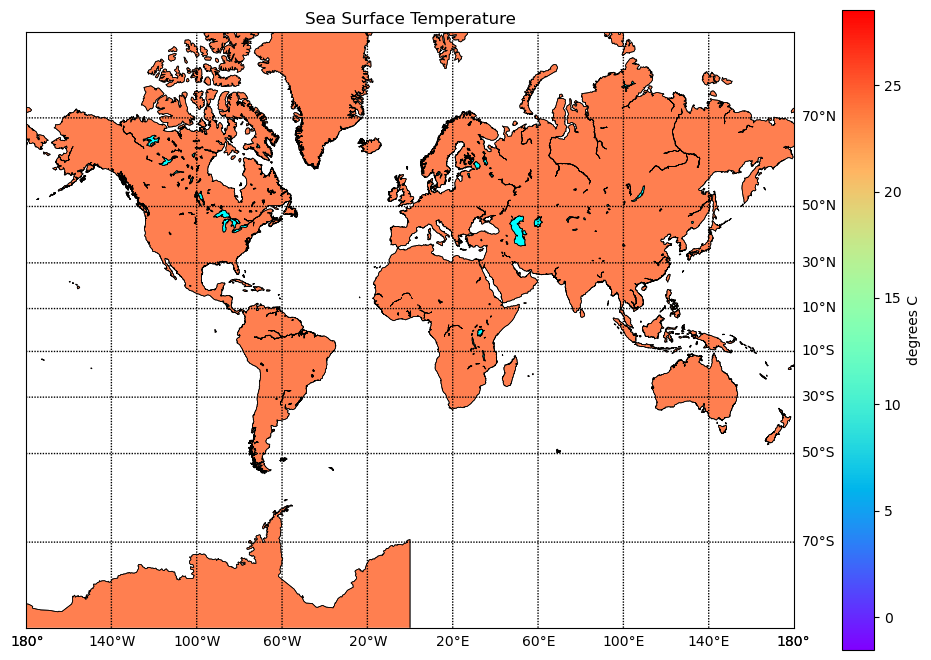

In [162]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

m = Basemap(
    llcrnrlon=-180,
    llcrnrlat=-80,
    urcrnrlon=180,
    urcrnrlat=80,
    resolution='l',
    projection='merc')

m.fillcontinents(color='coral',lake_color='aqua')

# draw lat and lon line (parallels and meridians).
# and set the axis labels (labels = [left,right,top,bottom])
parallels = np.arange(-70., 80., 20.)
m.drawparallels(parallels, labels=[False,True,False,False])
meridians = np.arange(-180., 180., 40.)
m.drawmeridians(meridians, labels=[False,False,False,True])

# Use meshgrid(lon, lat) to build matrices for the lon, lat values
# and then convert them to map projection coordinates for the Basemap
# object 'm.'
X, Y = m(*np.meshgrid(lon, lat))


# Plot using the rainbox color map
colors_ = m.pcolor(X, Y, sst[0,:,:], cmap=plt.get_cmap('rainbow'))

m.drawcoastlines(linewidth=0.5)

cb = plt.colorbar(colors_)
cb.set_label("degrees C")
m.drawcoastlines(linewidth=0.5)

ax.set_title('Sea Surface Temperature')